#### Description: 

Adding 10 HH Compartments back to back (conneced by 'raxial' and 'axial') and control the conductances so that the compartments do not spike.<br>
Passing the stimulus into the compartments by means of pulsegens assigned to each compartment. The pulsegens are connected to corresponding spikegens which are passing the stimulus spike to the corresponding compartments. The pulsegens are passing current for 20 ms each and between each current pulse there is a 20ms break. 

In [1]:
# importing libraries and modules
import moose
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.express as px

In [2]:
sim=moose.Neutral('/sim')
model=moose.Neutral('/sim/model')
data=moose.Neutral('/sim/data')
lib=moose.Neutral('/library')

In [3]:
# setting up numerical values of some parameters
# compartments will be cylindrical
erest=-70e-3 # resting potential of compartment
ENa=115e-3 + erest
EK=-12e-3 + erest
radius=5e-6  # radius of compartment
length=20e-6 # length of compartment
Cm_spec=1e-2 # specific capacitance
Gm_spec=3    # specific conductance
sarea=2*np.pi*radius*length

In [4]:
sarea

6.283185307179588e-10

In [5]:
# function for defining a prototype compartment. # compartment has synapse, spikegen and HHChannels
def get_proto_comp():
    comp_path=f'{lib.path}/comp'
    if moose.exists(comp_path):
        return moose.element(comp_path)

    # We can vary the parameters and see the effects on the membrane potential of the soma
    proto_comp=moose.Compartment(comp_path)
    proto_comp.Rm=1/(3*sarea) # membrane resistance= 1/(specific conductance * surface area)
    proto_comp.Cm=1e-2*sarea  # membrane capacitance= specific capacitance * surface area
    proto_comp.initVm=erest   # initial membrane potential
    proto_comp.Em= -60e-3  # reversal potential of compartment
    proto_comp.Ra=proto_comp.Rm # value used: Ra=35.4 ohm/cm 
    proto_comp.length=length  # length of compartment
    proto_comp.diameter=2*radius # radius of compartment

    # setting up channels

    nachan=moose.HHChannel(f'{proto_comp.path}/Na')
    kchan=moose.HHChannel(f'{proto_comp.path}/K')

    moose.connect(nachan,'channel',proto_comp,'channel')
    moose.connect(kchan,'channel',proto_comp,'channel')

    # setting some channel parameters
    
    nachan.Ek= ENa
    nachan.Gbar= 120 * 10 * sarea # 120 mS/cm^2 in HHM exp. In SI, we multiply by 10
    nachan.Xpower=3 # for m gating particle
    nachan.Ypower=1 # for h gating particle

    kchan.Ek= EK
    kchan.Gbar= 36 * 10 * sarea # 36 mS/cm^2 in HHM exp
    kchan.Xpower=4 # for n gating particle

    # setting up the gates

    n_gate=moose.HHGate(f'{kchan.path}/gateX')
    m_gate=moose.HHGate(f'{nachan.path}/gateX')
    h_gate=moose.HHGate(f'{nachan.path}/gateY')

    vmin=-100e-3
    vmax=100e-3
    vdivs=2000
    v=np.linspace(vmin,vmax,vdivs) # for interpolation purposes
    

    #Expressions for alpha and beta for gates m,h,n

    m_gate_alphaExpr = 1e3 * 0.1 * (25 - 1e3 * (v - (erest)))/(np.exp((25 - 1e3 * (v - (erest)))/10) - 1)
    m_gate_betaExpr =  1e3 * 4 * np.exp(- 1e3 * (v - (erest))/ 18)
    h_gate_alphaExpr = 1e3 * 0.07 * np.exp(- 1e3 * (v - (erest))/ 20)
    h_gate_betaExpr = 1e3 / (np.exp((30 - 1e3 * (v - (erest))) / 10) + 1)
    n_gate_alphaExpr = 1e3 * 0.01 * (10 - 1e3 * (v - (erest))) / (np.exp((10 - 1e3 * (v - (erest)))/10) - 1)
    n_gate_betaExpr = 1e3 * 0.125 * np.exp(-1e3 * (v - (erest)) / 80)


    # Now, using interpolation we will calculate the values of alpha and beta at different voltages
    # in a given range
    n_gate.tableA=n_gate_alphaExpr
    n_gate.tableB=n_gate_alphaExpr + n_gate_betaExpr
    m_gate.tableA=m_gate_alphaExpr
    m_gate.tableB=m_gate_alphaExpr + m_gate_betaExpr
    h_gate.tableA=h_gate_alphaExpr 
    h_gate.tableB=h_gate_alphaExpr + h_gate_betaExpr

    n_gate.min,n_gate.max,n_gate.divs=vmin,vmax,vdivs
    m_gate.min,m_gate.max,m_gate.divs=vmin,vmax,vdivs
    h_gate.min,h_gate.max,h_gate.divs=vmin,vmax,vdivs
    
    n_gate.useInterpolation=True
    m_gate.useInterpolation=True
    h_gate.useInterpolation=True

    # setting up the synapse

    # We will not include a spikegen for the compartment itself as it is getting the spike signal from the corresponding 
    # external spikegen 
    
    synchan=moose.SynChan(f'{proto_comp.path}/synchan')
    moose.connect(synchan,'channel',proto_comp,'channel')

    synh=moose.SimpleSynHandler(f'{synchan.path}/synh')
    moose.connect(synh,'activationOut',synchan,'activation')

    synh.numSynapses=1

    # parameters of the synapse
    
    synchan.Gbar=1e-8
    synchan.Ek=0e-3 # reversal potential of synaptic channel
    synchan.tau1=1e-3
    synchan.tau2=1e-3

    synh.synapse[0].weight=0.2
    synh.synapse[0].delay=1e-3

    
    return proto_comp

def get_pulsegen(): # external pulsegen corresponding to each compartment
    pulsegen_path=f'{lib.path}/pulsegen'
    if moose.exists(pulsegen_path):
        return moose.element(pulsegen_path)

    proto_pulsegen=moose.PulseGen(pulsegen_path)
    proto_pulsegen.level[0]=0
    proto_pulsegen.width[0]=20e-3

    return proto_pulsegen
    # we will set the delay timing in the for loop corresponding to each compartment

def get_spikegen(): # External spikegen for each compartment
    spikegen_path=f'{lib.path}/spikegen'
    if moose.exists(spikegen_path):
        return moose.element(spikegen_path)

    proto_spikegen=moose.SpikeGen(spikegen_path)
    proto_spikegen.threshold=50e-12

    return proto_spikegen

In [6]:
proto_comp=get_proto_comp() # creating a prototype compartment object by calling the function
proto_spikegen=get_spikegen() # creating a prototype spikegen object
proto_pulsegen=get_pulsegen() # creating a prototype pulsegen object

In [7]:
moose.showfield(moose.element(f'{proto_comp.path}/Na'))


[/library[0]/comp[0]/Na]
Ek                  =0.045
Gbar                =7.539822368615505e-07
Gk                  =0.0
Ik                  =0.0
X                   =0.0
Xpower              =3.0
Y                   =0.0
Ypower              =1.0
Z                   =0.0
Zpower              =0.0
className           =HHChannel
dt                  =5e-05
fieldIndex          =0
idValue             =488
index               =0
instant             =0
modulation          =1.0
name                =Na
numData             =1
numField            =1
path                =/library[0]/comp[0]/Na[0]
tick                =4
useConcentration    =0



'\n[/library[0]/comp[0]/Na]\nEk                  =0.045\nGbar                =7.539822368615505e-07\nGk                  =0.0\nIk                  =0.0\nX                   =0.0\nXpower              =3.0\nY                   =0.0\nYpower              =1.0\nZ                   =0.0\nZpower              =0.0\nclassName           =HHChannel\ndt                  =5e-05\nfieldIndex          =0\nidValue             =488\nindex               =0\ninstant             =0\nmodulation          =1.0\nname                =Na\nnumData             =1\nnumField            =1\npath                =/library[0]/comp[0]/Na[0]\ntick                =4\nuseConcentration    =0\n'

In [8]:
# Setting up lists to keep objects and tables
comps=[] 
vm_tabs=[] 
pulsegens=[]
spikegens=[]
pulsegen_tabs=[]
synchan_cond_tabs=[]
nachan_cond_tabs=[]  # list to store tables for measuring sodium channel conductance
kchan_cond_tabs=[]   # list to store tables for measuring potassium channel conductance

ncomps=10 # number of compartments

for i in range(ncomps):
    
    comp_hold=moose.copy(proto_comp,model,f'comp_{i}') # object to hold 'i'th compartment for current iteration
    pulsegen_hold=moose.copy(proto_pulsegen,model,f'pulsegen_{i}') # object to hold pulsegen for 'i'th compartment
    spikegen_hold=moose.copy(proto_spikegen,model,f'spikegen_{i}') # object to hold spikegen for 'i'th compartment

    # Setting up corresponding tables
    
    vm_tab=moose.Table(f'{data.path}/vm_{i}') # Table to measure Vm of current compartment
    pulsegen_tab=moose.Table(f'{data.path}/pulsegen_{i}') # measuring current for the 'i'th pulsegen
    synchan_tab=moose.Table(f'{data.path}/synchan_Gk_{i}') # Table to measure Conductance of synchan of current compartment
    nachan_tab=moose.Table(f'{data.path}/Na_cond_{i}') # Table to measure Conductance of nachan of current compartment
    kchan_tab=moose.Table(f'{data.path}/K_cond{i}') # Table to measure Conductance of kchan of current compartment

    # Appending objects to their respective lists
    
    comps.append(comp_hold) 
    vm_tabs.append(vm_tab)
    pulsegens.append(pulsegen_hold)
    spikegens.append(spikegen_hold)
    pulsegen_tabs.append(pulsegen_tab)
    synchan_cond_tabs.append(synchan_tab)
    nachan_cond_tabs.append(nachan_tab)
    kchan_cond_tabs.append(kchan_tab)

    moose.connect(vm_tab,'requestOut',comps[i],'getVm') # connecting table to get membrane potential
    
    moose.connect(pulsegens[i],'output',spikegens[i],'Vm') # connecting external pulsegen to external spikegen
    
    moose.connect(spikegens[i],'spikeOut',moose.element(f'{comps[i].path}/synchan/synh').synapse[0],'addSpike')
    # connecting the external spikegen to the syanpse of the corresponding compartment
    
    moose.connect(pulsegen_tabs[i],'requestOut',pulsegens[i],'getOutputValue') # to measure current output by pulsegen
    moose.connect(synchan_tab,'requestOut',moose.element(f'{comps[i].path}/synchan'),'getGk')# measuring synaptic conductance
    moose.connect(nachan_tab,'requestOut',moose.element(f'{comps[i].path}/Na'),'getGk')# measuring Na chan conductance
    moose.connect(kchan_tab,'requestOut',moose.element(f'{comps[i].path}/K'),'getGk') # measuring K chan conductance
                  

    # connecting spikegen of one compartment to the synapse at SimpleSynHandler of the next compartment
    if len(comps)>1:
        
        moose.connect(comps[-2],'raxial',comps[-1],'axial')
        

In [9]:
for i in range(0,10):
    # setting the pulse gen delays:
    # 20 ms rest and then 20 ms current
    # 40 ms for each pulsegen
    # 400 ms total
    # sim runtime ~~ 450 ms
    n=2*i+1
    moose.element(pulsegens[i].path).delay[0]=(10e-3)*n
    moose.element(pulsegens[i].path).delay[1]=1e9

for i in range(0,10):
    print(f'Pulsegen_{i} activated at: {moose.element(pulsegens[i].path).delay[0]}')

Pulsegen_0 activated at: 0.01
Pulsegen_1 activated at: 0.03
Pulsegen_2 activated at: 0.05
Pulsegen_3 activated at: 0.07
Pulsegen_4 activated at: 0.09
Pulsegen_5 activated at: 0.11
Pulsegen_6 activated at: 0.13
Pulsegen_7 activated at: 0.15
Pulsegen_8 activated at: 0.17
Pulsegen_9 activated at: 0.19


In [10]:
runtime=450e-3
moose.reinit()
moose.start(runtime)

In [11]:
t=np.arange(len(vm_tabs[0].vector))*vm_tabs[0].dt*1e3

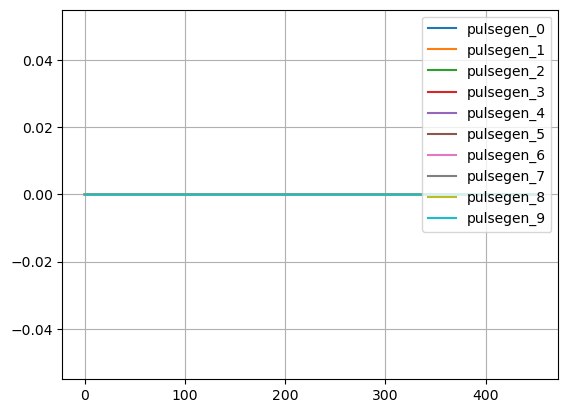

In [12]:
# plotting the current (PulseGen)
for i in range(ncomps):
    plt.plot(t,pulsegen_tabs[i].vector,label=f'pulsegen_{i}')

plt.grid()
plt.legend()
plt.show()

In [13]:
for i in range(ncomps):
    print(f'The spikegen_{i} fired at time: {np.round(moose.element(f'{spikegens[i].path}').lastSpikeTime,4)}')

The spikegen_0 fired at time: -0.0
The spikegen_1 fired at time: -0.0
The spikegen_2 fired at time: -0.0
The spikegen_3 fired at time: -0.0
The spikegen_4 fired at time: -0.0
The spikegen_5 fired at time: -0.0
The spikegen_6 fired at time: -0.0
The spikegen_7 fired at time: -0.0
The spikegen_8 fired at time: -0.0
The spikegen_9 fired at time: -0.0


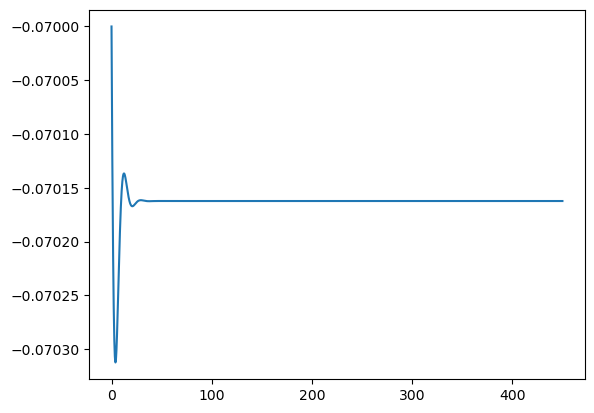

In [14]:
plt.plot(t,vm_tabs[9].vector)
plt.show()

In [17]:
moose.le(moose.element(comps[9].path))

Elements under /sim[0]/model[0]/comp_9[0]
    /sim[0]/model[0]/comp_9[0]/Na
    /sim[0]/model[0]/comp_9[0]/K
    /sim[0]/model[0]/comp_9[0]/synchan



['/sim[0]/model[0]/comp_9[0]/Na',
 '/sim[0]/model[0]/comp_9[0]/K',
 '/sim[0]/model[0]/comp_9[0]/synchan']

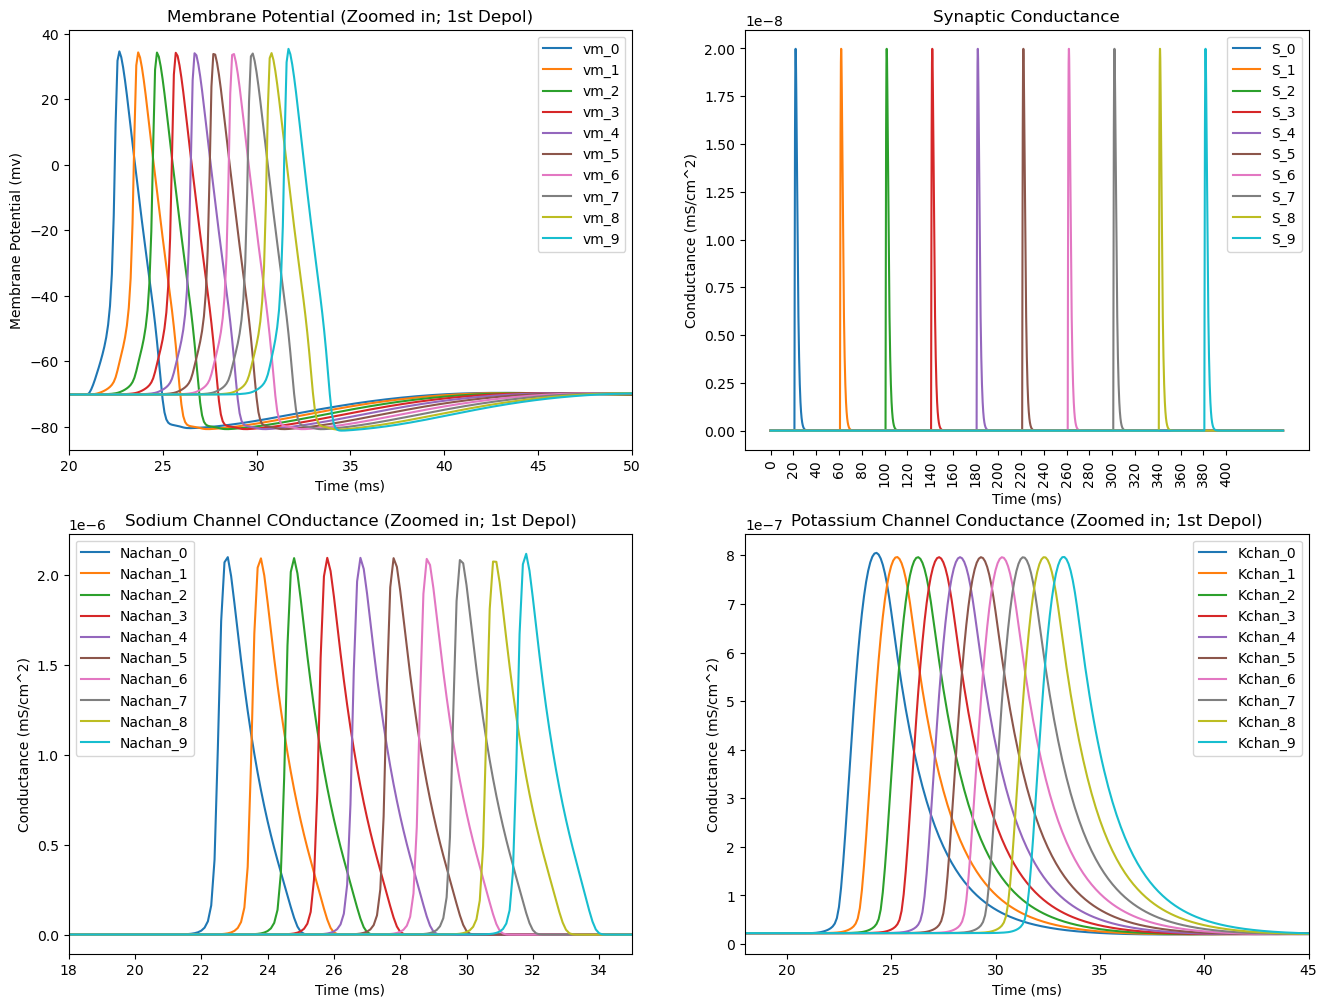

In [12]:
fig,axes=plt.subplots(2,2,figsize=(16,12))

for i in range(ncomps):
    axes[0][0].plot(t,vm_tabs[i].vector*1e3,label=f'vm_{i}')
    axes[0][0].set_title('Membrane Potentials')
    axes[0][0].set_xlabel('Time (ms)')
    axes[0][0].set_ylabel('Membrane Potential (mv)')
    axes[0][0].legend(loc='upper right')
    axes[0][0].set_xlim(20,50)
    if axes[0][0].get_xlim() == (20, 50):
        axes[0][0].set_title('Membrane Potential (Zoomed in; 1st Depol)')

# Remove plt.xlim() line to view plot across 450 ms

# We see this result as the current flows in both directions.
# When the 1st compartment is stimulated, the current flows towards the 10th compartment
# And when the 10th compartment is stimulated, the current flows towards the 1st compartment

# This is why, when we stimulate the first compartment, we see similar AP's in all the compartments as well 
# (after a certain time lag)


for i in range(ncomps):
    axes[0][1].plot(t,synchan_cond_tabs[i].vector*10,label=f'S_{i}')
axes[0][1].legend()
axes[0][1].set_ylabel('Conductance (mS/cm^2)')
axes[0][1].set_xlabel('Time (ms)')
axes[0][1].set_xticks(range(0, 420, 20))
axes[0][1].set_xticklabels(range(0, 420, 20), rotation=90)
axes[0][1].set_title('Synaptic Conductance')

for i in range(ncomps):
    axes[1][0].plot(t,nachan_cond_tabs[i].vector*10,label=f'Nachan_{i}')
axes[1][0].legend()
axes[1][0].set_ylabel('Conductance (mS/cm^2)')
axes[1][0].set_xlabel('Time (ms)')
axes[1][0].set_title('Sodium Channel Conductance')
axes[1][0].set_xlim(18,35)
if axes[1][0].get_xlim() == (18, 35):
        axes[1][0].set_title('Sodium Channel COnductance (Zoomed in; 1st Depol)')

for i in range(ncomps):
    axes[1][1].plot(t,kchan_cond_tabs[i].vector*10,label=f'Kchan_{i}')
axes[1][1].legend()
axes[1][1].set_ylabel('Conductance (mS/cm^2)')
axes[1][1].set_xlabel('Time (ms)')
axes[1][1].set_title('Potassium Channel Conductance')
axes[1][1].set_xlim(18,45)
if axes[1][1].get_xlim() == (18, 45):
        axes[1][1].set_title('Potassium Channel Conductance (Zoomed in; 1st Depol)')


plt.show()

In [13]:
for i in range(9,-1,-1):
    # setting the pulse gen delays:
    # 20 ms rest and then 20 ms current
    # 40 ms for each pulsegen
    # 400 ms total
    # sim runtime ~~ 450 ms
    n=2*i+1
    moose.element(pulsegens[9-i].path).delay[0]=(20e-3)*n
    moose.element(pulsegens[9-i].path).delay[1]=1e9

for i in range(0,10):
    print(f'Pulsegen_{i} activated at: {moose.element(pulsegens[i].path).delay[0]}')

Pulsegen_0 activated at: 0.38
Pulsegen_1 activated at: 0.34
Pulsegen_2 activated at: 0.3
Pulsegen_3 activated at: 0.26
Pulsegen_4 activated at: 0.22
Pulsegen_5 activated at: 0.18
Pulsegen_6 activated at: 0.14
Pulsegen_7 activated at: 0.1
Pulsegen_8 activated at: 0.06
Pulsegen_9 activated at: 0.02


In [14]:
runtime=450e-3
moose.reinit()
moose.start(runtime)

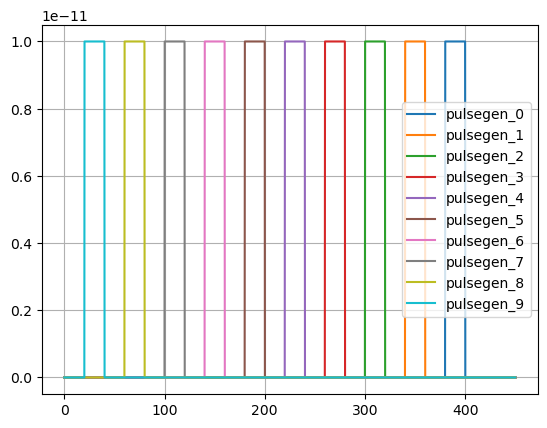

In [15]:
t=np.arange(len(vm_tabs[0].vector))*vm_tabs[0].dt*1e3

# plotting the current (PulseGen)
for i in range(ncomps):
    plt.plot(t,pulsegen_tabs[i].vector,label=f'pulsegen_{i}')

plt.grid()
plt.legend()
plt.show()

In [16]:
for i in range(ncomps):
    print(f'The spikegen_{i} fired at time: {np.round(moose.element(f'{spikegens[i].path}').lastSpikeTime,4)}')

The spikegen_0 fired at time: 0.38
The spikegen_1 fired at time: 0.34
The spikegen_2 fired at time: 0.3
The spikegen_3 fired at time: 0.26
The spikegen_4 fired at time: 0.22
The spikegen_5 fired at time: 0.18
The spikegen_6 fired at time: 0.14
The spikegen_7 fired at time: 0.1
The spikegen_8 fired at time: 0.06
The spikegen_9 fired at time: 0.02


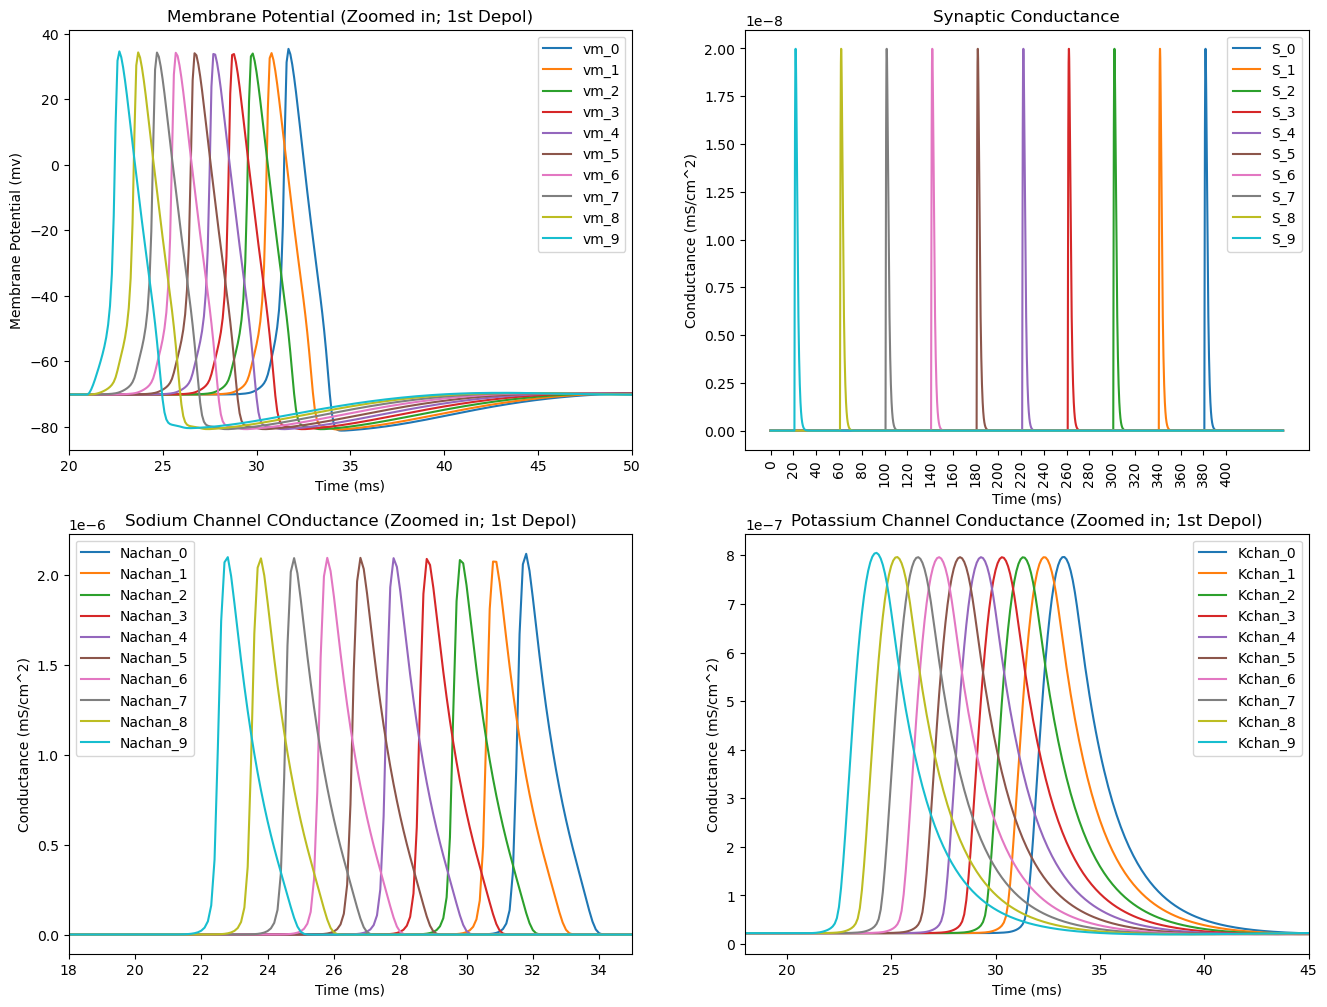

In [17]:
fig,axes=plt.subplots(2,2,figsize=(16,12))

for i in range(ncomps):
    axes[0][0].plot(t,vm_tabs[i].vector*1e3,label=f'vm_{i}')
    axes[0][0].set_title('Membrane Potentials')
    axes[0][0].set_xlabel('Time (ms)')
    axes[0][0].set_ylabel('Membrane Potential (mv)')
    axes[0][0].legend(loc='upper right')
    axes[0][0].set_xlim(20,50)
    if axes[0][0].get_xlim() == (20, 50):
        axes[0][0].set_title('Membrane Potential (Zoomed in; 1st Depol)')

# Remove plt.xlim() line to view plot across 450 ms

# We see this result as the current flows in both directions.
# When the 1st compartment is stimulated, the current flows towards the 10th compartment
# And when the 10th compartment is stimulated, the current flows towards the 1st compartment

# This is why, when we stimulate the first compartment, we see similar AP's in all the compartments as well 
# (after a certain time lag)


for i in range(ncomps):
    axes[0][1].plot(t,synchan_cond_tabs[i].vector*10,label=f'S_{i}')
axes[0][1].legend()
axes[0][1].set_ylabel('Conductance (mS/cm^2)')
axes[0][1].set_xlabel('Time (ms)')
axes[0][1].set_xticks(range(0, 420, 20))
axes[0][1].set_xticklabels(range(0, 420, 20), rotation=90)
axes[0][1].set_title('Synaptic Conductance')

for i in range(ncomps):
    axes[1][0].plot(t,nachan_cond_tabs[i].vector*10,label=f'Nachan_{i}')
axes[1][0].legend()
axes[1][0].set_ylabel('Conductance (mS/cm^2)')
axes[1][0].set_xlabel('Time (ms)')
axes[1][0].set_title('Sodium Channel Conductance')
axes[1][0].set_xlim(18,35)
if axes[1][0].get_xlim() == (18, 35):
        axes[1][0].set_title('Sodium Channel COnductance (Zoomed in; 1st Depol)')

for i in range(ncomps):
    axes[1][1].plot(t,kchan_cond_tabs[i].vector*10,label=f'Kchan_{i}')
axes[1][1].legend()
axes[1][1].set_ylabel('Conductance (mS/cm^2)')
axes[1][1].set_xlabel('Time (ms)')
axes[1][1].set_title('Potassium Channel Conductance')
axes[1][1].set_xlim(18,45)
if axes[1][1].get_xlim() == (18, 45):
        axes[1][1].set_title('Potassium Channel Conductance (Zoomed in; 1st Depol)')


plt.show()

In [18]:
# Below is the corresponding plotly code which allows the user to interact with the plot

In [19]:
# # For membrane potentials
# data_vm = []

# for i in range(ncomps):
#     vm = np.array(vm_tabs[i].vector) * 1e3  # Convert to mV
#     for time, voltage in zip(t, vm):
#         data_vm.append({'Time (ms)': time, 'Membrane Potential (mV)': voltage, 'Compartment': f'{i}'})

# df = pd.DataFrame(data_vm)

# fig = px.line(df, x='Time (ms)', y='Membrane Potential (mV)', color='Compartment',
#               title='Membrane Potentials')

# fig.update_layout(
#     xaxis_range=[15, 45],
#     xaxis_title='Time (ms)',
#     yaxis_title='Membrane Potential (mV)',
#     template='plotly_white',
#     showlegend=True
# )

# fig.show()




In [20]:
# # For synaptic conductance
# data_syn = []

# for i in range(ncomps):
#     cond = np.array(synchan_cond_tabs[i].vector) * 10  # Convert as in matplotlib code
#     for time, value in zip(t, cond):
#         data_syn.append({
#             'Time (ms)': time,
#             'Conductance (mS/cm^2)': value,
#             'Compartment': f'{i}'
#         })

# df = pd.DataFrame(data_syn)

# fig = px.line(df, x='Time (ms)', y='Conductance (mS/cm^2)', color='Compartment',
#               title='Synaptic Conductance')

# fig.update_layout(
#     xaxis_title='Time (ms)',
#     yaxis_title='Conductance (mS/cm^2)',
#     template='plotly_white',
#     showlegend=True
# )

# fig.show()

In [21]:
# # For Sodium Conductance
# data_nachan = []

# for i in range(ncomps):
#     cond = np.array(nachan_cond_tabs[i].vector) * 10  # Scale like original
#     for time, val in zip(t, cond):
#             data_nachan.append({
#                 'Time (ms)': time,
#                 'Conductance (mS/cm^2)': val,
#                 'Compartment': f'{i}'
#             })

# df_nachan = pd.DataFrame(data_nachan)

# fig = px.line(df_nachan, x='Time (ms)', y='Conductance (mS/cm^2)', color='Compartment',
#               title='Sodium Channel Conductance')

# fig.update_layout(
#     xaxis_range=[18,35],
#     xaxis_title='Time (ms)',
#     yaxis_title='Conductance (mS/cm^2)',
#     template='plotly_white',
#     showlegend=True
# )

# fig.show()

In [22]:
# # For Potassium Conductance
# data_kchan = []

# for i in range(ncomps):
#     cond = np.array(kchan_cond_tabs[i].vector) * 10  # Scale like original
#     for time, val in zip(t, cond):
#             data_kchan.append({
#                 'Time (ms)': time,
#                 'Conductance (mS/cm^2)': val,
#                 'Compartment': f'{i}'
#             })

# df_kchan = pd.DataFrame(data_kchan)

# fig = px.line(df_kchan, x='Time (ms)', y='Conductance (mS/cm^2)', color='Compartment',
#               title='Potassium Channel Conductance')

# fig.update_layout(
#     xaxis_range=[18,42],
#     xaxis_title='Time (ms)',
#     yaxis_title='Conductance (mS/cm^2)',
#     template='plotly_white',
#     showlegend=True
# )

# fig.show()